In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import quandl

import cvxportfolio as cp

Download the problem data from Quandl. We select four liquid stocks, and the risk-free rate.

In [3]:
tickers = ['AMZN', 'GOOGL', 'TSLA', 'NKE']
start_date='2012-01-01'
end_date='2016-12-31'
returns = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Close'].pct_change())
                for ticker in tickers]))
returns[["USDOLLAR"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/(250*100)
returns = returns.fillna(method='ffill').iloc[1:]

returns.tail()

,AMZN,GOOGL,NKE,TSLA,USDOLLAR
Date,,,,,
2016-12-23,-0.007503,-0.002322,-0.004411,0.023459,0.000020
2016-12-27,0.014213,0.002637,-0.011944,0.029015,0.000020
2016-12-28,0.000946,-0.006618,-0.005264,0.000957,0.000021
2016-12-29,-0.009040,-0.002101,0.000784,-0.023027,0.000018
2016-12-30,-0.019970,-0.012991,-0.004505,-0.004612,0.000020


We compute rolling estimates of the first and second moments of the returns using a window of 250 days. We shift them by one unit (so at every day we present the optimizer with only past data).

In [4]:
r_hat = returns.rolling(window=250, min_periods=250).mean().shift(1).dropna()
Sigma_hat = returns.rolling(window=250, min_periods=250, closed='neither').cov().dropna()

r_hat.tail()

,AMZN,GOOGL,NKE,TSLA,USDOLLAR
Date,,,,,
2016-12-23,0.000683,0.000219,-0.000660,-0.000074,0.000012
2016-12-27,0.000542,0.000150,-0.000706,-0.000124,0.000013
2016-12-28,0.000627,0.000179,-0.000691,-0.000023,0.000013
2016-12-29,0.000707,0.000215,-0.000664,-0.000052,0.000013
2016-12-30,0.000901,0.000302,-0.000598,0.000133,0.000013


Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

In [5]:
tcost_model=cp.TcostModel(half_spread=10E-4)
hcost_model=cp.HcostModel(borrow_costs=1E-4)

We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [6]:
risk_model = cp.FullSigma(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 5., 1., 1.
leverage_limit = cp.LeverageLimit(3)

spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model, gamma_hold*hcost_model],
                                constraints=[leverage_limit])

We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

In [10]:
market_sim=cp.MarketSimulator(returns, [tcost_model, hcost_model], cash_key='USDOLLAR') 
init_portfolio = pd.Series(index=returns.columns, data=250000.)
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(init_portfolio,
                               start_time='2014-01-03',  end_time='2016-12-31',  
                               policies=[spo_policy, cp.Hold()])
results[0].summary()

Number of periods                               755
Initial timestamp               2014-01-03 00:00:00
Final timestamp                 2016-12-30 00:00:00
Portfolio return (%)                          8.816
Excess return (%)                             8.681
Excess risk (%)                              18.424
Sharpe ratio                                  0.472
Max. drawdown                                20.011
Turnover (%)                                 94.748
Average policy time (sec)                     0.031
Average simulator time (sec)                  0.004


The total value of the portfolio in time.

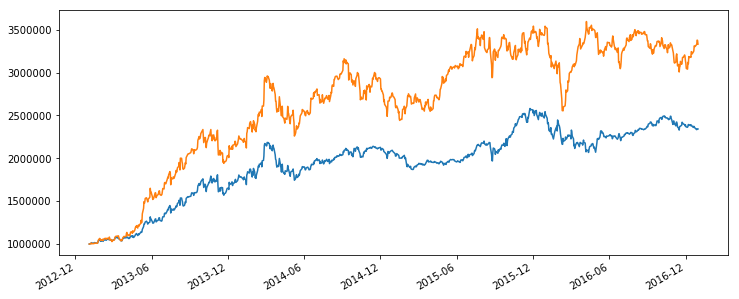

In [8]:
results[0].v.plot(figsize=(12,5))
results[1].v.plot(figsize=(12,5))

The weights vector of the portfolio in time.

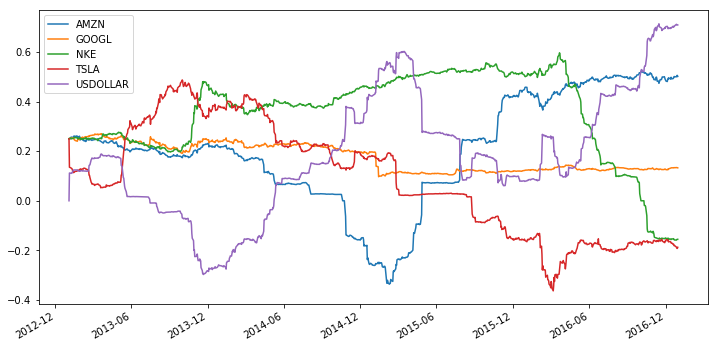

In [9]:
results[0].w.plot(figsize=(12,6))